# Chinese text summarization algorithm
### www.KudosData.com
#### By: Sam GU Zhan
#### March, 2017

# Imports

In [1]:
# coding=UTF-8
from __future__ import division
import re

# Python2 unicode & float-division support:
# from __future__ import unicode_literals, division

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import io

# 中文字符和语言处理库
import jieba

# 机器学习库 sklearn 分类学习模型库
#from sklearn import linear_model
from sklearn.feature_extraction import DictVectorizer # 数据结构变换：把 Dict 转换为 稀疏矩阵
# from sklearn.linear_model import LogisticRegression  # 逻辑回归分类模型
# from sklearn.pipeline import make_pipeline # 封装机器学习模型流程
# from sklearn.metrics import confusion_matrix, roc_curve, auc

# 中文显示设置
from pylab import *  
mpl.rcParams['font.sans-serif'] = ['SimHei'] # 指定默认字体  
mpl.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题 
mpl.rcParams['font.size'] = 14 # 设置字体大小

np.random.seed(88)

# Define Functions

In [3]:
# Python3
# 中文分词功能小函数， 输出 字符串， 各词组由空格分隔
def KudosData_word_tokenizer(foo):
    # remove lead & tail spaces firstly:
    foo = foo.strip()
    seg_token = jieba.cut(str(foo), cut_all=True)
    seg_str = str(' '.join(seg_token)).strip()

    return seg_str
# Python2
# 中文分词功能小函数， 输出 字符串， 各词组由空格分隔
# def KudosData_word_tokenizer(foo):
#     seg_token = jieba.cut(foo, cut_all=True)
#     seg_str = ' '.join(seg_token)
#     return seg_str

In [4]:
# Python3
# 中文分词功能小函数， 输出 dictionary： { key 词组， value 计数 }
def KudosData_word_count(foo):
    # remove lead & tail spaces firstly:
    foo = foo.strip()
    seg_token = jieba.cut(str(foo), cut_all=True)
    seg_str = str(' '.join(seg_token)).strip()
    seg_count = pd.value_counts(str(seg_str).lower().split(' '))
    seg_count = seg_count.to_dict() 
    seg_count.pop('', None) # remove EMPTY dict key: ''
    return seg_count
# Python2
# 中文分词功能小函数， 输出 dictionary： { key 词组， value 计数 }
# def KudosData_word_count(foo):
#     seg_token = jieba.cut(foo, cut_all=True)
#     seg_str = '^'.join(seg_token)
#     seg_count = pd.value_counts(seg_str.lower().split('^'))
#     return seg_count.to_dict()

# Input text

In [5]:
# process Unicode text input
with io.open('input_text.txt','r',encoding='utf8') as f:
    content = f.read()

title = '''
<Dummy Title>
'''

In [6]:
# content

In [7]:
def format_sentence(text):
#     sentence = re.sub(r'\W+', '#', sentence)
    text = re.sub(r'\t+', '', text) # remove one or more Tab
    return text

In [8]:
def extract_valid_sentence_words(text):
    text = re.sub(r'\W+', '#', text.strip())
    return text

In [9]:
def linebreak_conversion_win_linux(text):
    text = re.sub(r'\r', '', text) # remove one or more Tab
    text = re.sub(r'\u3000', ' ', text) # convert white space: \u3000    
    return text

In [10]:
def clean_some_whitespace(text): # Does not remove normal Space
#     sentence = re.sub(r'\W+', '#', sentence)
    text = re.sub(r'\t+', '', text) # remove one or more Tab
    text = re.sub(r'\f+', '', text) # remove one or more
    text = re.sub(r'\v+', '', text) # remove one or more
    text = re.sub(r'\n+', '', text) # remove one or more \n, this is to merge sentences within paragraph

    text = re.sub(r'(\^\*\#)( +)(\#\*\^)', '^*##*^', text) # remove one or more Spaces between Paragraph-Tags or Sentence-Tags

    text = re.sub(r' +', ' ', text) # merge two or more Spaces to 1 Space

    # remove lead & tail spaces:
    text =text.strip()

#     text = re.sub(r'( +)\W', r'\W', text) # remove Spaces before special char
#     text = re.sub(r'\W( +)', r'\W', text) # remove Spaces after special char
    
    return text

In [11]:
### Define Paragraph-Tag =  
#   #*^P^*#

### Define Sentence-Tag =  
#   #*^S^*#


In [12]:
# add a special tage to end of each paragraph
def tag_paragraph(text):
    text = re.sub(r'((\n ) +)+', '#*^P^*#', text) # Tag paragraph, pattern: \n + two or more Spaces
    text = re.sub(r'((\n\t) +)+', '#*^P^*#', text) # Tag paragraph, pattern: \n + two or more Tabs
    text = re.sub(r'(\n( *)\n)+', '#*^P^*#', text) # Tag paragraph, pattern: \n + zero or more Spaces + \n
    text = re.sub(r'(\#\*\^P\^\*\#)+', '#*^P^*#', text) # merge two or more Paragraph-Tags -> 1 Paragraph-Tag

    return text

In [13]:
# add a special tage to end of each sentence
def tag_sentence(text):
    text = re.sub(r'。+', '。#*^S^*#', text) # Tag sentence - Chinese
    text = re.sub(r'！+', '！#*^S^*#', text) # Tag sentence - Chinese
    text = re.sub(r'\？+', '？#*^S^*#', text) # Tag sentence - Chinese
    text = re.sub(r'；+', '；#*^S^*#', text) # Tag sentence - Chinese

    text = re.sub(r'!+', '!#*^S^*#', text) # Tag sentence - English
    text = re.sub(r'\?+', '?#*^S^*#', text) # Tag sentence - English
    text = re.sub(r';+', ';#*^S^*#', text) # Tag sentence - English
   
    # merge two or more sentence-Tags -> 1 Sentence-Tag
    text = re.sub(r'(\W?(\#\*\^S\^\*\#))+', '。#*^S^*#', text)

    # remove a Sentence-Tag immediately before an ending ”
    text = re.sub(r'\#\*\^S\^\*\#”', '”', text) 
    
    # remove a Sentence-Tag immediately before a Paragraph-Tag
    text = re.sub(r'(\#\*\^S\^\*\#)( *)(\#\*\^P\^\*\#)', '#*^P^*#', text) 
    
    text = re.sub(r'(\#\*\^P\^\*\#)+', '#*^P^*#', text) # merge two or more Paragraph-Tags -> 1 Paragraph-Tag

    
    return text

### Start tagging:

In [14]:
content_format = linebreak_conversion_win_linux(content)
# content_format

In [15]:
content_format = tag_paragraph(content_format)
# content_format

In [16]:
content_format = clean_some_whitespace(content_format)
# content_format

In [17]:
content_format = tag_sentence(content_format)
# content_format

In [18]:
content_format = clean_some_whitespace(content_format)
content_format

'汉语[编辑]维基百科，自由的百科全书#*^P^*#本条目存在隐藏的内容，可能损害或改善读者的阅览体验。#*^S^*#请协助改善条目，以符合维基百科的标准。#*^S^*#（2015年9月12日） 一般应该仅由特定标准化模板提供折叠资料表格，勿因故事剧情或项目混杂而隐藏。#*^S^*#内容应该考虑其他方式呈现。#*^S^*#重复记载、过度细节与无助了解主题的堆砌内容等需要考虑除去。#*^S^*#中文重定向于此，书面语参见：汉语书面语，文字参见：汉字。#*^S^*#关于中国人使用的语言，参见：中国语言。#*^S^*#两岸三地、东南亚官方、非官方组织，各自对于汉语的定义、语音、词汇，参见：现代标准汉语。#*^P^*#汉语Hanyu trad simp.svg正体字和简体字书写的“汉语”区域中国大陆、香港、澳门、台湾、新加坡、马来西亚、印度尼西亚、泰国、越南、柬埔寨、缅甸、圣诞岛以及世界各地的华人社区母语使用人数约15亿(2015)[1]（5000万人作为第二语言）（日期不详）#*^P^*#语系汉藏语系汉语族汉语早期形式上古汉语中古汉语近代汉语汉语#*^P^*#标准形式现代标准汉语粤语方言官话晋语吴语（含上海话）徽语赣语湘语闽北语闽南语闽东语闽中语莆仙语客家语粤语瓦乡话文字汉字、注音符号、汉语拼音、小儿经#*^P^*#官方地位作为官方语言 中华人民共和国 香港 澳门 中华民国 新加坡承认少数语言 加拿大 马来西亚 美国 印尼 英国 菲律宾管理机构中华民国 教育部终身教育司中华人民共和国 国家语言文字工作委员会新加坡 推广华语理事会马来西亚 华语规范理事会香港 语文教育及研究常务委员会#*^P^*#语言代码ISO 639-1zhISO 639-2chi （B）zho （T）ISO 639-3分别为：cdo－闽东语cjy－晋语cmn－官话cpx－莆仙语czh－徽语czo－闽中语dng－东干语gan－赣语hak－客家语hsn－湘语ltc－中古汉语lzh－文言文mnp－闽北语nan－闽南语och－上古汉语wuu－吴语wxa－瓦乡话yue－粤语汉语使用者分布作为主要语言、官方语言及母语多于500万使用者多于100万使用者多于50万使用者多于10万使用者汉语使用者主要居住点#*^P^*#汉语Map of sinitic languages full-zh.svg大中华区汉语言分布图语言


### Transfer tagged text to Pandas Dataframe

In [19]:
# Split a text into paragraphs
def split_article_to_paragraphs(text):
#     text = text.replace("#*^P^*#", "#*^S^*#") # convert Paragraph-Tag        
    return text.split("#*^P^*#")


In [20]:
# Split a paragraph into sentences
def split_paragraph_to_sentences(text):
#     text = text.replace("#*^P^*#", "#*^S^*#") # convert Paragraph-Tag        
    return text.split("#*^S^*#")


In [21]:
# 1st loop Paragraphs list, 2nd loop Sentences list
# create a few new columns, then write into dataframe, together with original Sentence string

# define empty dataframe:
df_article = pd.DataFrame(columns=('sentence', 
                                   'word_count', # sentence word count, including punctuations 
                                   'sentence_id', # unique sentence s/n within an article
                                   'sentence_id_paragraph',  # sentence s/n within a paragraph 
                                   'paragraph_id', 
                                   'class_rank', 
                                   'score_word', # score based on word tf-idf
                                   'score_sentence', # score based on intersection of sentence pairs
                                   'score_word_norm', # Normalized score
                                   'score_sentence_norm', # Normalized score
                                   'score',
                                  ))
df_sentence_id = 0

# split_article_to_paragraphs:
article_paragraphs = split_article_to_paragraphs(content_format)

for i in range(0, len(article_paragraphs)):
    # split_paragraph_to_sentences:
    article_paragraphs_sentences = split_paragraph_to_sentences(article_paragraphs[i].strip())

    for j in range(0, len(article_paragraphs_sentences)):
        if article_paragraphs_sentences[j].strip() != '':
            df_sentence_id = df_sentence_id + 1
            # write to dataframe:
            df_article.loc[len(df_article)] = [article_paragraphs_sentences[j].strip(), 
                                               len(article_paragraphs_sentences[j].strip()), 
                                               df_sentence_id, 
                                               j+1, 
                                               i+1, 
                                               '', 
                                               '', 
                                               '', 
                                               '', 
                                               '', 
                                               '']


In [22]:
# Make sure no empty sentences:
print('Number of empty sentences in dataframe: %d ' % len(df_article[df_article['sentence'] == '']))

Number of empty sentences in dataframe: 0 


In [23]:
df_article

,sentence,word_count,sentence_id,sentence_id_paragraph,paragraph_id,class_rank,score_word,score_sentence,score_word_norm,score_sentence_norm,score
0,汉语[编辑]维基百科，自由的百科全书,18,1,1,1,,,,,,
1,本条目存在隐藏的内容，可能损害或改善读者的阅览体验。,26,2,1,2,,,,,,
2,请协助改善条目，以符合维基百科的标准。,19,3,2,2,,,,,,
3,（2015年9月12日） 一般应该仅由特定标准化模板提供折叠资料表格，勿因故事剧情或项目混杂...,50,4,3,2,,,,,,
4,内容应该考虑其他方式呈现。,13,5,4,2,,,,,,
5,重复记载、过度细节与无助了解主题的堆砌内容等需要考虑除去。,29,6,5,2,,,,,,
6,中文重定向于此，书面语参见：汉语书面语，文字参见：汉字。,28,7,6,2,,,,,,
7,关于中国人使用的语言，参见：中国语言。,19,8,7,2,,,,,,
8,两岸三地、东南亚官方、非官方组织，各自对于汉语的定义、语音、词汇，参见：现代标准汉语。,43,9,8,2,,,,,,
9,汉语Hanyu trad simp.svg正体字和简体字书写的“汉语”区域中国大陆、香港、澳...,132,10,1,3,,,,,,


In [24]:
# assume the 1st sentence as Title of Article

title = df_article['sentence'][0]
print('Title of Article : ', title)

Title of Article :  汉语[编辑]维基百科，自由的百科全书


# Calculate importance score for each sentence

### [Optional Reference] word_tokenizer

In [25]:
# KudosData_word_tokenizer
df_article['sentence_tokenized'] = df_article['sentence'].apply(lambda x: KudosData_word_tokenizer(x))

Building prefix dict from the default dictionary ...
DEBUG:jieba:Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\TELESC~1\AppData\Local\Temp\jieba.cache
DEBUG:jieba:Loading model from cache C:\Users\TELESC~1\AppData\Local\Temp\jieba.cache
Loading model cost 2.577 seconds.
DEBUG:jieba:Loading model cost 2.577 seconds.
Prefix dict has been built succesfully.
DEBUG:jieba:Prefix dict has been built succesfully.


### [Optional Reference] Term Frequency

In [26]:
# KudosData_word_count
df_article['sentence_tf'] = df_article['sentence'].apply(lambda x: KudosData_word_count(x))

### [Optional Reference] TF-IDF

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
corpus = df_article['sentence_tokenized']

vectorizer = TfidfVectorizer()

# my_stopword_list = ['and','to','the','of', 'in']
#vectorizer = TfidfVectorizer(stop_words=my_stopword_list)

# choice of no nomalization of tfidf output (not recommended)
#vectorizer = TfidfVectorizer(norm=None)

# TF-IDF score
tfidf = vectorizer.fit_transform(corpus)

# IDF score
idf_dict = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))

# TF is in df_article[['sentence_tf']]

In [28]:
### 把TF-iDF数值赋予相对应的词组
tfidf = tfidf.tocsr()

n_docs = tfidf.shape[0]
tfidftables = [{} for _ in range(n_docs)]
terms = vectorizer.get_feature_names()

for i, j in zip(*tfidf.nonzero()):
    tfidftables[i][terms[j]] = tfidf[i, j]

In [29]:
# Document-Term-Matrix's TF-IDF matrix size:
print ('This tfidf matrix is a very large table: [ %d rows/docs X %d columns/words ]' 
       % (tfidf.shape[0], tfidf.shape[1]))
print ('It contains %d eliments: one score per word per document !'
       % (tfidf.shape[0] * tfidf.shape[1]))

This tfidf matrix is a very large table: [ 220 rows/docs X 1559 columns/words ]
It contains 342980 eliments: one score per word per document !


In [30]:
# Add tfidf score into dataframe 
df_article['tfidf'] = tfidftables

In [31]:
# df_article[['sentence', 'sentence_tokenized', 'tfidf']].head()
df_article[['sentence', 'sentence_tokenized', 'sentence_tf', 'tfidf']]

,sentence,sentence_tokenized,sentence_tf,tfidf
0,汉语[编辑]维基百科，自由的百科全书,汉语 编辑 维基 维基百 维基百科 百科 自由 的 百科 百科全书 全书,"{'维基百': 1, '百科': 2, '的': 1, '汉语': 1, '维基百科': 1...","{'维基百': 0.301724971112, '维基': 0.301724971112, ..."
1,本条目存在隐藏的内容，可能损害或改善读者的阅览体验。,本条 条目 存在 隐藏 的 内容 可能 损害 或 改善 读者 的 阅览 体验,"{'读者': 1, '存在': 1, '本条': 1, '的': 2, '损害': 1, '...","{'内容': 0.293154410813, '读者': 0.333698004443, '..."
2,请协助改善条目，以符合维基百科的标准。,请 协助 改善 条目 以 符合 维基 维基百 维基百科 百科 的 标准,"{'条目': 1, '请': 1, '百科': 1, '符合': 1, '维基百': 1, ...","{'符合': 0.352630088976, '维基': 0.352630088976, '..."
3,（2015年9月12日） 一般应该仅由特定标准化模板提供折叠资料表格，勿因故事剧情或项目混杂...,2015 年 9 月 12 日 一般 应该 仅 由 特定 定标 标准 标准化 模板 提...,"{'2015': 1, '年': 1, '日': 1, '模板': 1, '混杂': 1, ...","{'表格': 0.243957743437, '应该': 0.204775340083, '..."
4,内容应该考虑其他方式呈现。,内容 应该 考虑 其他 方式 呈现,"{'内容': 1, '呈现': 1, '方式': 1, '其他': 1, '应该': 1, ...","{'内容': 0.405911360688, '呈现': 0.462049370729, '..."
5,重复记载、过度细节与无助了解主题的堆砌内容等需要考虑除去。,重复 记载 过度 细节 与 无助 了解 主题 的 堆砌 内容 等 需要 考虑 除去,"{'内容': 1, '重复': 1, '的': 1, '与': 1, '除去': 1, '堆...","{'内容': 0.265491960777, '除去': 0.302209805615, '..."
6,中文重定向于此，书面语参见：汉语书面语，文字参见：汉字。,中文 重定向 定向 于此 书面 书面语 参见 汉语 书面 书面语 文字 参见 汉字,"{'重定向': 1, '于此': 1, '中文': 1, '书面': 2, '汉语': 1,...","{'重定向': 0.306002169008, '定向': 0.306002169008, ..."
7,关于中国人使用的语言，参见：中国语言。,关于 中国 国人 使用 的 语言 参见 中国 国语 语言,"{'使用': 1, '国语': 1, '关于': 1, '国人': 1, '语言': 2, ...","{'语言': 0.358382300032, '国语': 0.305218189007, '..."
8,两岸三地、东南亚官方、非官方组织，各自对于汉语的定义、语音、词汇，参见：现代标准汉语。,两岸 两岸三地 东南 东南亚 南亚 官方 非官方 官方 组织 各自 对于 汉语 ...,"{'南亚': 1, '组织': 1, '的': 1, '参见': 1, '现代': 1, '...","{'南亚': 0.249761457402, '词汇': 0.209829325055, '..."
9,汉语Hanyu trad simp.svg正体字和简体字书写的“汉语”区域中国大陆、香港、澳...,汉语 Hanyu trad simp svg 正体 正体字 和 简体 简体字 字书 书写 的...,"{'缅甸': 1, 'svg': 1, '各地': 1, '不详': 1, '作为': 1,...","{'缅甸': 0.152531235609, 'simp': 0.152531235609,..."


### Scoring (1)
### Calculate score_word for each sentence, based on sentence word_count tf-idf:

In [32]:
# experiment: use tf-idf and len(sentence_tokenized) to calculate score
# tmp_mean = tmp_sum / len(df_article['sentence_tokenized'][i])

for i in range(0,len(df_article)):
    if len(df_article['tfidf'][i]) == 0:
        df_article['score_word'][i] = 0
    else:
        tmp_sum = 0
        for key, values in df_article['tfidf'][i].items():
            tmp_sum += values
        
        tmp_mean = tmp_sum / len(df_article['sentence_tokenized'][i])
        df_article['score_word'][i] = tmp_mean 


G:\Tool_PGM\Anaconda3\lib\site-packages\ipykernel\__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
G:\Tool_PGM\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Scoring (2)
### Calculate score_sentence for each sentence, based on pair-wise sentence comparison/intersection:

In [33]:
# Caculate raw intersection score between pair of two sentences, from df_article['sentence_tokenized']
def sentences_intersection(sent1tokenized, sent2tokenized):
    # www.KudosData.com - Chinese
    # split the sentence into words/tokens
    s1 = set(sent1tokenized.split(" "))
    s2 = set(sent2tokenized.split(" "))

    # If there is not intersection, just return 0
    if (len(s1) + len(s2)) == 0:
        print('# If there is not intersection, just return 0')
        return 0

    # Normalize the result by the average number of words
    return len(s1.intersection(s2)) / ((len(s1) + len(s2)) / 2)


### Below step runs long time... Tuning needed

In [34]:
# Calculate important score of every pair of sentences

n = len(df_article['sentence_tokenized'])
        
# [Sam python 2.7 -> 3.4] values = [[0 for x in xrange(n)] for x in xrange(n)]
df_score_raw_values = [[0 for x in range(n)] for x in range(n)]
for i in range(0, n):
    for j in range(0, n):
        df_score_raw_values[i][j] = sentences_intersection(df_article['sentence_tokenized'][i], 
                                                           df_article['sentence_tokenized'][j])

# The score of a sentence is the sum of all its intersection
sentences_dic = {}

for i in range(0, n):
    df_score = 0
    for j in range(0, n):
        if i == j:
            continue
        df_score += df_score_raw_values[i][j]
    df_article['score_sentence'][i] = df_score


G:\Tool_PGM\Anaconda3\lib\site-packages\ipykernel\__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [35]:
# df_article.head()

### Visualize Data

In [36]:
df_article[df_article['word_count'] == None]

,sentence,word_count,sentence_id,sentence_id_paragraph,paragraph_id,class_rank,score_word,score_sentence,score_word_norm,score_sentence_norm,score,sentence_tokenized,sentence_tf,tfidf


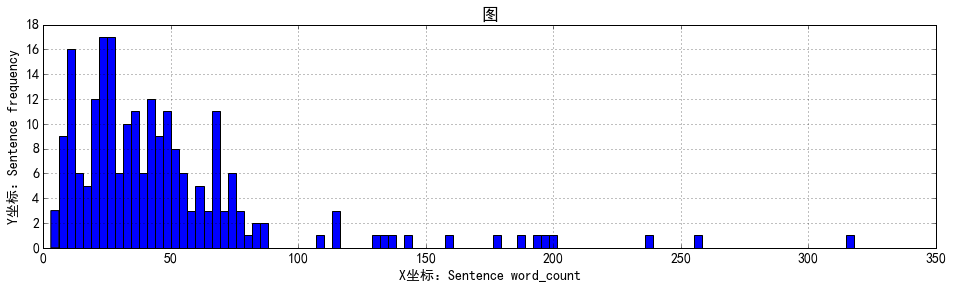

In [37]:
# 图表显示：
plt.figure(figsize=(16, 4))
plt.title(u'图')  
plt.xlabel(u'X坐标：Sentence word_count')  
plt.ylabel(u'Y坐标：Sentence frequency')  
# df_article['word_count'].value_counts().sort_values(ascending=False).plot(kind='bar', color='green')
df_article['word_count'].hist(bins=100)
# plt.gca().invert_yaxis()
plt.show()


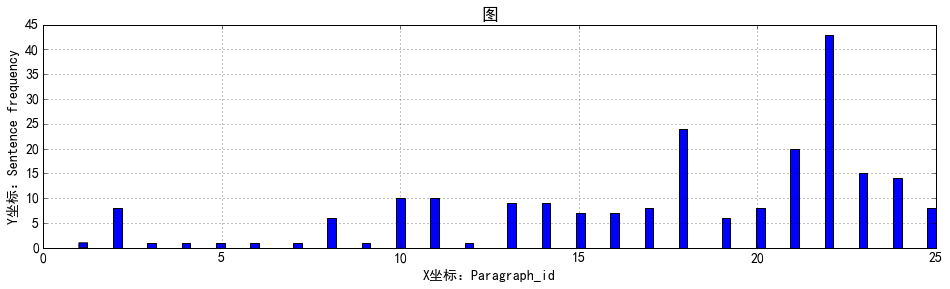

In [38]:
# 图表显示：
plt.figure(figsize=(16, 4))
plt.title(u'图')  
plt.xlabel(u'X坐标：Paragraph_id')  
plt.ylabel(u'Y坐标：Sentence frequency')  
df_article['paragraph_id'].hist(bins=100)
# plt.gca().invert_yaxis()
plt.show()


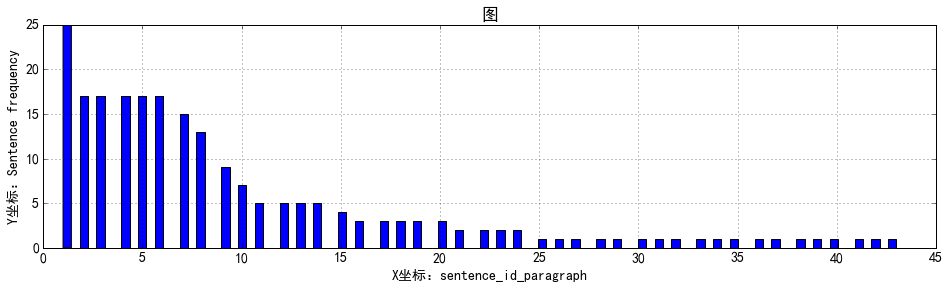

In [39]:
# 图表显示：
plt.figure(figsize=(16, 4))
plt.title(u'图')  
plt.xlabel(u'X坐标：sentence_id_paragraph')  
plt.ylabel(u'Y坐标：Sentence frequency')  
df_article['sentence_id_paragraph'].hist(bins=100)
# plt.gca().invert_yaxis()
plt.show()


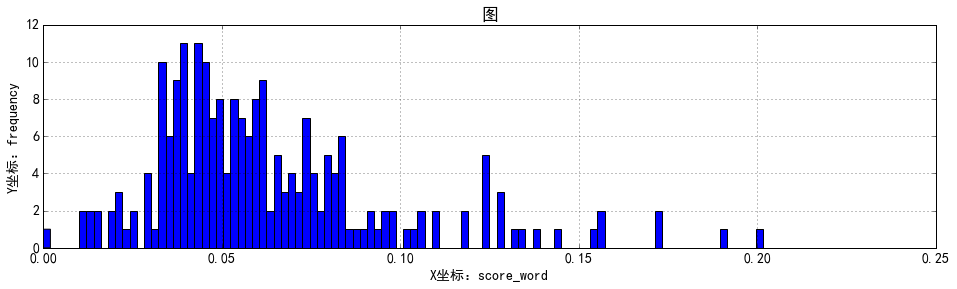

In [40]:
# 图表显示：
plt.figure(figsize=(16, 4))
plt.title(u'图')  
plt.xlabel(u'X坐标：score_word')  
plt.ylabel(u'Y坐标：frequency')  
df_article['score_word'].hist(bins = 100)
# plt.xscale('log')
# plt.yscale('log')
#plt.xlim(0,0.5)
#plt.ylim(0,0.5)
# plt.gca().invert_yaxis()
plt.show()


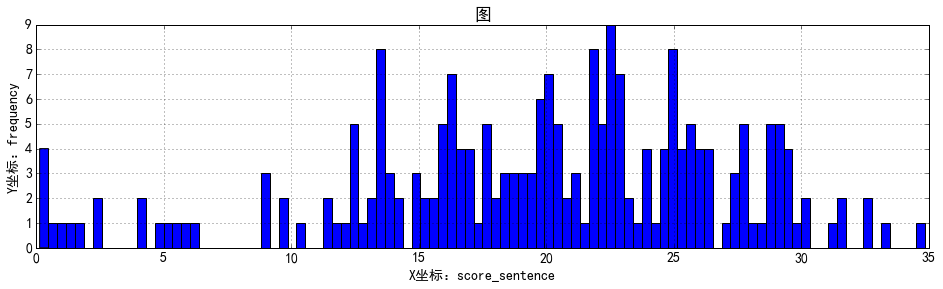

In [41]:
# 图表显示：
plt.figure(figsize=(16, 4))
plt.title(u'图')  
plt.xlabel(u'X坐标：score_sentence')  
plt.ylabel(u'Y坐标：frequency')  
df_article['score_sentence'].hist(bins = 100)
# plt.xscale('log')
# plt.yscale('log')
#plt.xlim(0,0.5)
#plt.ylim(0,0.5)
# plt.gca().invert_yaxis()
plt.show()


In [42]:
# df_article[(df_article['score_word'] > 0.15) & (df_article['score_word'] < 0.25)]
# df_article[(df_article['score_word'] > 0.2)].sort_values(by=['score_sentence', 'score_word'], ascending=[False, False,])
# df_article[(df_article['score_sentence'] > 250)].sort_values(by=['score_word', 'score_sentence'], ascending=[False, False,])


### Score Normalization

In [43]:
# log(score_word)
df_article['score_word_log'] = np.log(df_article['score_word'].astype('float64') + 
                                      df_article[df_article['score_word'] >0 ]['score_word'].min()/2)


In [44]:
# Normalize score_word_log

# df_article['score_word_norm'] = (df_article['score_word'] - df_article['score_word'].mean()) / df_article['score_word'].std()
df_article['score_word_norm'] = (df_article['score_word_log'] - df_article['score_word_log'].mean()) / df_article['score_word_log'].std()

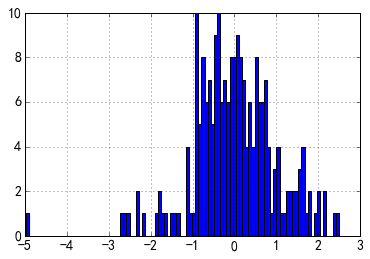

In [45]:
df_article['score_word_norm'].hist(bins=100)

In [46]:
# Normalize score_sentence

df_article['score_sentence_norm'] = (df_article['score_sentence'] - df_article['score_sentence'].mean()) / df_article['score_sentence'].std()

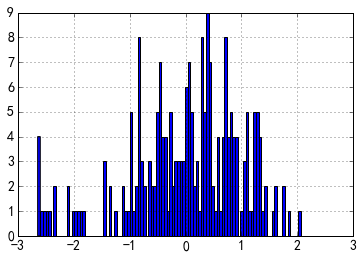

In [47]:
df_article['score_sentence_norm'].hist(bins=100)

### Generate class_rank

In [48]:
# Score integration
# df_article['score'] = (df_article['score_sentence_norm'] + df_article['score_word_norm']) / 2

# Sam Gu: 23 Mar 2017 - Experiment found that the score_word, which is based on tf-idf, doesn't seem to work well.
#                       Hence, here we use score_sentence only for final scoring.

df_article['score'] = df_article['score_sentence_norm']

In [49]:
# Min-Max normalization:
df_article['score'] = (df_article['score'] - df_article['score'].min()) / (df_article['score'].max() -df_article['score'].min())

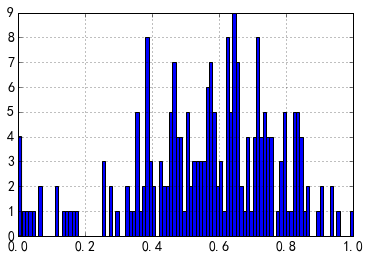

In [50]:
df_article['score'].hist(bins=100)

In [51]:
# sort firstly
df_article = df_article.sort_values(by=['paragraph_id', 'score'], ascending=[True, False]).reset_index(drop=True)

### Below step runs long time... Tuning needed

In [52]:
# Generate Class_Rank

current_class_rank = 0
current_paragraph_id = 0

for i in range(0, len(df_article)):
    if df_article['paragraph_id'][i] != current_paragraph_id: # change of Paragraph, thus reset class_rank
        current_class_rank = 1
        current_paragraph_id = df_article['paragraph_id'][i]
    else:
        current_class_rank = current_class_rank + 1
        
    df_article['class_rank'][i] = current_class_rank


G:\Tool_PGM\Anaconda3\lib\site-packages\ipykernel\__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [53]:
# sort Dataframe to 'result lookup mode'
df_article = df_article.sort_values(by=['class_rank', 'score', 'paragraph_id', 'sentence_id'], 
                                    ascending=[True, False, True, True]).reset_index(drop=True)

In [54]:
# df_article[['sentence',
#            'paragraph_id',
#            'sentence_id_paragraph',
#            'class_rank',
#            'score',
#            'sentence_tokenized'
#           ]]

In [55]:
# df_article[(df_article['score'] == 0) | (df_article['score'] == 1)]

# Extract results based on user parameters:
Max number of words

% of original number of words, etc

In [88]:
# Make a dataframe copy
df_article_internal = pd.DataFrame.copy(df_article)

In [89]:
# Sam Gu: experiment shows no major improvement to use code in this block:

'''

# Heuristic cleaning:
# 1.Remove sentences, which has only one valid word. 
# 2.Remove paragraph, which has only single sentence.

# 1.
df_article_internal = df_article_internal[df_article_internal['sentence_tokenized'].map(len) > 1]
print('*** www.KudosData.com *** Removed number of sentences, which has only one valid word : %d'
      % (len(df_article) - len(df_article_internal)))

# 2.
df_article_internal_paragraph = df_article_internal['paragraph_id'].value_counts().to_frame(name = 'sentence_count')
df_article_internal_paragraph = df_article_internal_paragraph[df_article_internal_paragraph['sentence_count'] > 1]
valid_paragraph_id = df_article_internal_paragraph.index.tolist()
df_article_internal = df_article_internal[df_article_internal['paragraph_id'].isin(valid_paragraph_id)] 
print('*** www.KudosData.com *** Removed number of sentences in total : %d' % (len(df_article) - len(df_article_internal)))

# sort Dataframe to 'result lookup mode'
df_article_internal = df_article_internal.sort_values(by=['class_rank', 'score', 'paragraph_id', 'sentence_id'], 
                                    ascending=[True, False, True, True]).reset_index(drop=True)
# Above sort a must sort !!! for below processing:
# Loop Dataframe, accumulate length of sentences, stop when parm_max_word reached, return the index(), cut dataframe to display

'''

"\n\n# Heuristic cleaning:\n# 1.Remove sentences, which has only one valid word. \n# 2.Remove paragraph, which has only single sentence.\n\n# 1.\ndf_article_internal = df_article_internal[df_article_internal['sentence_tokenized'].map(len) > 1]\nprint('*** www.KudosData.com *** Removed number of sentences, which has only one valid word : %d'\n      % (len(df_article) - len(df_article_internal)))\n\n# 2.\ndf_article_internal_paragraph = df_article_internal['paragraph_id'].value_counts().to_frame(name = 'sentence_count')\ndf_article_internal_paragraph = df_article_internal_paragraph[df_article_internal_paragraph['sentence_count'] > 1]\nvalid_paragraph_id = df_article_internal_paragraph.index.tolist()\ndf_article_internal = df_article_internal[df_article_internal['paragraph_id'].isin(valid_paragraph_id)] \nprint('*** www.KudosData.com *** Removed number of sentences in total : %d' % (len(df_article) - len(df_article_internal)))\n\n# sort Dataframe to 'result lookup mode'\ndf_article_intern

In [90]:
total_words_original_article = df_article['sentence'].map(len).sum()
total_words_internal_article = df_article_internal['sentence'].map(len).sum()

print('total_words_original_article : ', total_words_original_article)
print('total_words_internal_article : ', total_words_internal_article)


total_words_original_article :  10530
total_words_internal_article :  10530


### Accept user parameters:

In [91]:
parm_max_word = 500

# range: [0, 1]
parm_max_percent = .05

### blank line

In [92]:
# cut by parm_max_percent

# Loop Dataframe, accumulate length of sentences, stop when parm_max_word reached, return the index(), cut dataframe to display

sum_current_word = 0
cut_index = len(df_article_internal['sentence'])

# print('Start loop...')
for s in range(0, len(df_article_internal['sentence'])):
#     print('s : %d' % s)
    if sum_current_word / total_words_original_article <= parm_max_percent:
        sum_current_word += len(df_article_internal['sentence'][s])
    else:
#         stop, return index number
        cut_index = s - 1
        sum_current_word -= len(df_article_internal['sentence'][s-1])

#         print('To break')
        break

# print('End loop')
sum_current_percent = sum_current_word / total_words_original_article
print('sum_current_word  / total_words_original_article:', sum_current_percent)
print('cut_index : ', cut_index)

sum_current_word  / total_words_original_article: 0.04985754985754986
cut_index :  16


In [93]:
# cut by parm_max_word

# Loop Dataframe, accumulate length of sentences, stop when parm_max_word reached, return the index(), cut dataframe to display

sum_current_word = 0
cut_index = len(df_article_internal['sentence'])

# print('Start loop...')
for s in range(0, len(df_article_internal['sentence'])):
#     print('s : %d' % s)
    if sum_current_word <= parm_max_word:
        sum_current_word += len(df_article_internal['sentence'][s])
    else:
#         stop, return index number
        cut_index = s - 1
        sum_current_word -= len(df_article_internal['sentence'][s-1])
#         print('To break')
        break

# print('End loop')
print('sum_current_word :', sum_current_word)
print('cut_index : ', cut_index)

sum_current_word : 465
cut_index :  15


In [94]:
# Extract top number of sentences as summary, based on: cut_index
df_article_final = df_article_internal[0:cut_index]

In [95]:
# sort by original sentence order 
df_article_final = df_article_final.sort_values(by=['sentence_id'], ascending=[True])
df_article_final[['sentence', 'paragraph_id', 'sentence_id_paragraph', 'class_rank', 'score']]

,sentence,paragraph_id,sentence_id_paragraph,class_rank,score
13,汉语[编辑]维基百科，自由的百科全书,1,1,1,0.801059
12,关于中国人使用的语言，参见：中国语言。,2,7,1,0.823701
1,它们的语言学归属在西方语言学界存在争议，或被认为是独立的语言，[2]或被认为是汉语方言。,8,6,1,0.934864
14,在非表音情况下，仅指现代白话文的书面语。,10,2,1,0.794897
2,在中国，这13种“语言”往往被学者们当作汉语的“方言”。,11,3,1,0.931784
4,文体[编辑]汉语作为以语素文字为文字系统的语言，文字高度的统一与规范，现代汉语有统一和规范的语法。,13,1,1,0.901229
9,西方的古汉语先锋是瑞典的语言学家高本汉，他主要研究汉字的形式和诗经的韵律。,14,9,1,0.836093
11,正如印欧语系的语言可以由现代印欧语言重构一样，中古汉语也可以由方言重建。,15,5,1,0.824028
10,现代汉语[编辑]主条目：现代标准汉语发展历史现代汉语是以北方官话为基础方言，并以典范的现代白...,16,5,1,0.834385
7,汉语书面语较为统一，但各方言之间的口语与词汇有一定差异。,17,4,1,0.855783


# Output results to a file

In [96]:
# print('\n'.join(list(df_article_final['sentence'])))

In [97]:

with io.open('output_topic_summary.txt','w',encoding='utf8') as f:
#     f.write("Original Length : %s" % total_words_original_article)
    f.write("No. Paragraphs  : %d" % df_article_internal['paragraph_id'].max())
    f.write("\n")
    f.write("Original Length : %s" % total_words_internal_article)
    f.write("\n")
    f.write("Summary  Length : %s" % sum_current_word)
    f.write("\n")
#     f.write("Summary  Ratio  : %s %%" % (100 * (sum_current_word / total_words_original_article)))
    f.write("Summary  Ratio  : %.2f %%" % (100 * (sum_current_word / total_words_internal_article)))
    f.write("\n")
    f.write("\n")
    f.write("Title of Article: %s" % title)
    f.write("\n")
    f.write("\n")
    f.write('\n'.join(list(df_article_final['sentence'])))
    f.close()
    